In [936]:
import pandas as pd
import numpy as np

In [937]:
def print_board(board):
    board_cp = board.copy()
    
    board_cp[np.where(board_cp == "")] = " "
    print(np.reshape(board_cp, (3,3)))

def is_winning_board(board, winner = ['X', 'O']):
    
    ways_to_win = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 4, 8], [2, 4, 6]])

    i = 0
    check_win = False

    while(check_win is False and i < len(ways_to_win)):
        
        win_vec = ways_to_win[i]
        
        vals_x = [board[w]== "X" for w in win_vec]
        vals_o = [board[w]== "O" for w in win_vec]
        
        if winner == 'X':
            check_win = (sum(vals_x) == 3)
        elif winner == 'O':
            check_win = (sum(vals_o) == 3)
        else:
             check_win = (sum(vals_x) == 3) | (sum(vals_o) == 3)
            
        i = i + 1    

    return check_win

def is_almost_win(board, for_player = "X"):
    
    ways_to_win = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 4, 8], [2, 4, 6]])

    i = 0
    
    check_awin = False

    while(check_awin is False and i < len(ways_to_win)):
        
        j = 0
        
        win_vec = ways_to_win[i]
                        
        ways_to_almost_win = [win_vec[combo] for combo in [[0,1], [1,2], [0,2]]]
        
        while(check_awin is False and j < len(ways_to_almost_win)):
                            
            awin_vec = ways_to_almost_win[j] 
                        
            vals_player = [board[w] == for_player for w in awin_vec]
            
            vals_open = [board[w] == "" for w in win_vec]            
            
            check_awin = (sum(vals_player) == 2) and (sum(vals_open) == 1)
            
            j = j + 1
            
        i = i + 1    
                        
    how_to_win = ways_to_win[i-1]    
    
    if check_awin:
        which_play = how_to_win[np.where(np.array(board)[how_to_win] == "")[0][0]]
    else:
        which_play = []
    
    return which_play, check_awin

def is_full_board(board):
    return sum([board[i] in ["X", "O"] for i in range(9)]) == 9

def unique_boards(all_boards):
    return [np.array(x) for x in set(tuple(x) for x in all_boards)]

def get_baseline_value(board):
    
    if is_winning_board(board, winner = 'X'):
        return 1    
    elif is_winning_board(board, winner = 'O') or is_full_board(board):
        return 0
    else:
        return .5
    
def get_value_board(board, value_df):
    if board is None:
        return .5
    else:
        board_df = pd.DataFrame([board])
        return board_df.merge(value_df, how = "left")['value'].loc[0]
    
def get_n_action_board(board, value_df):
    if board is None:
        return 0
    else:
        board_df = pd.DataFrame([board])
        return board_df.merge(value_df, how = "left")['n_action'].loc[0]

def baseline_value_table():

    round = 0
    player_turns = ['X', 'O', 'X', 'O', 'X', 'O', 'X', 'O', 'X']

    prev_round_boards = [np.array(["", "", "", "", "", "", "", "", ""])]

    all_boards = prev_round_boards

    while(round < 9):

        current_player = player_turns[round]
        round_boards = []

        for prev_board in prev_round_boards:

            if not is_winning_board(prev_board):
                still_open = np.where(prev_board == '')[0]

                for move in still_open:
                    new_board = prev_board.copy()
                    new_board[move] = current_player
                    round_boards = round_boards + [new_board]

        round_boards_unique = unique_boards(round_boards)

        prev_round_boards =  round_boards_unique

        all_boards = all_boards + round_boards_unique

        round = round + 1
        
        init_values = [get_baseline_value(board) for board in all_boards]

        value_df = pd.DataFrame(all_boards)

        all_boards_str = [','.join(board) for board in all_boards]

        value_df['board_str'] = all_boards_str

        value_df['value'] = init_values
        
    value_df['n_action'] = 0 

    return value_df


Let the learner play 300 rounds of games against a random-selection oponent with decaying learning rate and epsilon in epsilon-greedy strategy.

$V(S_t) \leftarrow V(S_t) + \alpha[ V(S_{t+1}) - V(S_t)]$ 

For example, if $\alpha  = .1$ and $V(S_t) = .4$ and $V(S_{t+1})$ = .5, then $V(S_t)$ becomes 0.41.    

Epsilon = % of time the learner takes a random step
(otherwise it takes the move with the highest 

In [938]:
def learner_move_egreedy(curr_board, prev_board, epsilon, alpha, player = 'X', apply_symm = True):
    
    still_open = np.where(curr_board == '')[0]
    
    next_boards = []

    for move in still_open:
        next_board = curr_board.copy()
        next_board[move] = 'X'
        next_boards = next_boards + [next_board]

    greedy = np.random.random_sample() > epsilon

    values = [get_value_board(board, value_df) for board in next_boards]

    if greedy:
        choices = still_open[np.where(values == max(values))]
        if len(choices) > 1:
            next_move = np.random.choice(choices)
        else:
            next_move = choices[0]
    else:
        next_move = np.random.choice(still_open)

    new_board = curr_board.copy()
    new_board[next_move] = player

    new_board_value = get_value_board(new_board, value_df)

    if prev_board is not None:

        prev_board_str = ','.join(prev_board)
        prev_board_value = get_value_board(prev_board, value_df)

        prev_board_value  = prev_board_value + alpha*(new_board_value - prev_board_value)    
        
        if apply_symm:
        
            symmetries = [[0,1,2,3,4,5,6,7,8], [2,5,8,1,4,7,0,3,6], [8,7,6,5,4,3,2,1,0], [6,3,0,7,4,1,8,5,2]]
            boards_symm = [prev_board[switch] for switch in symmetries]
           
            for board in boards_symm:
                board_str = ','.join(board)
                value_df.loc[value_df['board_str'] == board_str, 'value'] = prev_board_value

        else:
            value_df.loc[value_df['board_str'] == prev_board_str, 'value'] = prev_board_value

    return new_board

# not being used
def random_move(curr_board, player = 'O'):
    still_open = np.where(curr_board == '')[0]

    next_move = np.random.choice(still_open)
    
    new_board = curr_board.copy()
    new_board[next_move] = player
    
    return new_board

def smartish_move(curr_board, player = 'O'):
    
    opponent = np.asscalar(np.where(player == "O", "X", "O"))
        
    me_best_move, me_win = is_almost_win(curr_board, for_player = player)
        
    op_best_move, op_win = is_almost_win(curr_board, for_player = opponent)
    
    # can I win? --> so win then
    if me_win:
        new_board = curr_board.copy()
        new_board[me_best_move] = player
        
    # is other player about to win? --> block them
    elif op_win:
        new_board = curr_board.copy()        
        new_board[op_best_move] = player
    
    # otherwise pick randomly
    else:
        still_open = np.where(np.array(curr_board) == '')[0]
        
        next_move = np.random.choice(still_open)

        new_board = curr_board.copy()
        new_board[next_move] = player

    return new_board

def make_move(curr_board, prev_board, turn, epsilon, alpha, RL_player = 'X'):
    
    if turn in [0,2,4,6,8]:
        new_board = learner_move(curr_board, prev_board, epsilon, alpha, player = RL_player)
        
    else:
        comp_player = np.asscalar(np.where(RL_player == 'X', 'O', 'X'))
        new_board = smartish_move(curr_board, player = comp_player)
        
    return new_board

def which_turns_value_changes(old_value_df, new_value_df):
    merge_df = old_value_df.merge(new_value_df, on = [0,1,2,3,4,5,6,7,8, 'board_str'], suffixes = ["_old", "_new"])
        
    changes_df = merge_df.loc[merge_df['value_old'] != merge_df['value_new']].reset_index(drop = True)
        
    def get_row_turn(data, row):
        return sum(data.loc[row][:9] != "")
        
    turns_changed = [get_row_turn(changes_df, row) for row in list(range(changes_df.shape[0]))]
    
    return turns_changed

def play_round(epsilon, alpha, show = False):
    
    old_value_df = value_df.copy()
    
    prev_board = None
    curr_board = np.array(['', '', '', '', '', '', '', '', ''])

    turn = 0

    check_win = False

    while(turn < 9 and check_win is False):
                
        new_board = make_move(curr_board, prev_board, turn, epsilon, alpha)
        
        if show:
            print_board(new_board)

        x_wins = is_winning_board(new_board, 'X')
        o_wins = is_winning_board(new_board, 'O')

        check_win = x_wins or o_wins

        prev_board = curr_board.copy()
        curr_board = new_board.copy()
        turn = turn + 1
        
    new_value_df = value_df.copy()
    
    turns_change = which_turns_value_changes(old_value_df, new_value_df)

    if x_wins:
        ending = "X wins"
    elif o_wins:
        ending = "O wins"
    else:
        ending = "cats"
        
    return curr_board, turns_change, ending

def play_all_rounds(alpha_list, epsilon_list):
    
    value_df = baseline_value_table()
    
    print(value_df.value.value_counts())
    
    num_epochs = len(alpha_list)
    
    win_list = []
    turns_list = []
    
    for i in range(num_epochs):
        if i % 100 == 0:
            print(i)
        
        end_board, turns_change, winner = play_round(epsilon_list[i], alpha_list[i])
        
        if len(turns_change) > 0:
            turns_list.append(turns_change)
        else:
            turns_list.append([-99])
            
        win_list = win_list + [winner]   
        
    return win_list, turns_list

In [939]:
value_df = baseline_value_table()

value_df.head()

,0,1,2,3,4,5,6,7,8,board_str,value,n_action
0,,,,,,,,,,",,,,,,,,",0.5,0
1,X,,,,,,,,,"X,,,,,,,,",0.5,0
2,,,,,X,,,,,",,,,X,,,,",0.5,0
3,,,,,,,X,,,",,,,,,X,,",0.5,0
4,,,,,,,,,X,",,,,,,,,X",0.5,0


In [940]:
epsilon_list = np.arange(1, .1, -.0002)
alpha_list = np.array([.3] * len(epsilon_list))

wins, turns = play_all_rounds(alpha_list, epsilon_list)

0.5    4520
1.0     626
0.0     332
Name: value, dtype: int64
0


KeyboardInterrupt: 

In [ ]:
wins_df = pd.DataFrame({'ending':wins})

wins_df['iter'] = range(wins_df.shape[0])

wins_df['iter_group'] = wins_df['iter'].apply(lambda num: num - (num % 250))

wins_df_group = wins_df.groupby('iter_group')['ending'].value_counts().rename(columns = {'': ''}).reset_index().rename(columns = {0:'count_val'})

wins_df_group['ending_cat'] = pd.Categorical(wins_df_group['ending'], categories = ['O wins', 'cats', 'X wins'], ordered = True)

print(wins_df_group.head())

(p9.ggplot(wins_df_group, p9.aes(x = 'factor(iter_group)', fill = 'ending_cat', y = 'count_val')) + 
p9.geom_col() +
p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=0))
)

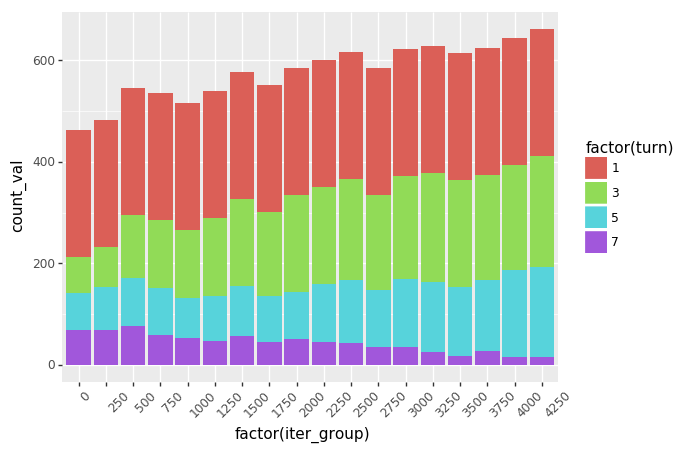

<ggplot: (7556266083)>

In [795]:
turns_df = pd.DataFrame([[i, val] for i in range(len(turns)) for val in turns[i]], columns = ['iter', 'turn'])

turns_df['iter_group'] = turns_df['iter'].apply(lambda num: num - (num % 250))

turns_df_group = turns_df.groupby('iter_group')['turn'].value_counts().rename(columns = {'': ''}).reset_index().rename(columns = {0:'count_val'})

turns_df_group_lim = turns_df_group.loc[turns_df_group['turn'] != -99]

(p9.ggplot(turns_df_group_lim, p9.aes(x = 'factor(iter_group)', y = 'count_val', fill = 'factor(turn)')) + 
p9.geom_col() +
p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=0))
)

(1057, 11)


/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


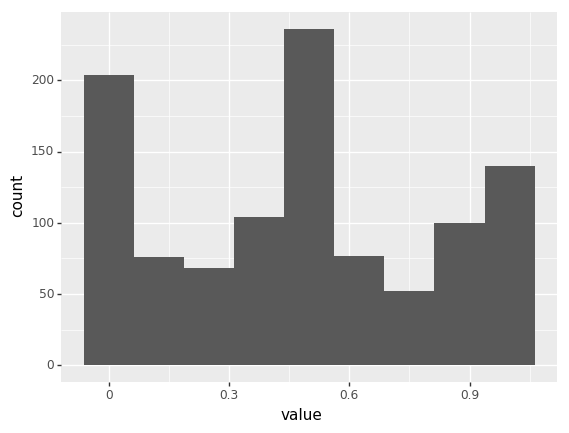

<ggplot: (7557815588)>

In [823]:
new_values = value_df.loc[~value_df['value'].isin([0, 0.5, 1])]

print(new_values.shape)

p9.ggplot(new_values, p9.aes(x = 'value')) + p9.geom_histogram()

In [942]:
def learner_move_ucb(curr_board, prev_board, c, t, player = 'X', apply_symm = True):
    
    still_open = np.where(curr_board == '')[0]
    
    next_boards = []

    for move in still_open:
        next_board = curr_board.copy()
        next_board[move] = 'X'
        next_boards = next_boards + [next_board]

    # change action to UCB
    
    values = [get_value_board(board, value_df) for board in next_boards]
    
#    print('values')
#    print(values)
    
    n_action = [get_n_action_board(board, value_df) for board in next_boards]
#    print('n_a')
#    print(n_action)
    
    if any(np.array(n_action) == 0):
        choices = still_open[np.where(np.array(n_action) == 0)]        
    else:
#         print('still open')
#         print(still_open)

#         print('n_action')
#         print(n_action)
        
#         print('values')
#         print(values)
        
        
        def UCB(Q, N, c, t):
            return Q + c*np.sqrt(np.log(t)/N)
        
        action_scores = [UCB(values[i], n_action[i], c, t) for i in range(len(values))] 
        
#         print('action_scores')
#         print(action_scores)
        
        choices = still_open[np.where(action_scores == max(action_scores))]
        
    if len(choices) > 1:
        next_move = np.random.choice(choices)
    else:
        next_move = choices[0]

    new_board = curr_board.copy()
    new_board[next_move] = player

    new_board_value = get_value_board(new_board, value_df)
    
    new_board_str = ','.join(new_board)
    prev_n_action = value_df.loc[value_df['board_str'] == new_board_str, 'n_action']
    value_df.loc[value_df['board_str'] == new_board_str, 'n_action'] =  prev_n_action + 1

    if prev_board is not None:

        prev_board_str = ','.join(prev_board)
        prev_board_value = get_value_board(prev_board, value_df)

        prev_board_value  = prev_board_value + alpha*(new_board_value - prev_board_value)
                
        if apply_symm:
        
            symmetries = [[0,1,2,3,4,5,6,7,8], [2,5,8,1,4,7,0,3,6], [8,7,6,5,4,3,2,1,0], [6,3,0,7,4,1,8,5,2]]
            boards_symm = [prev_board[switch] for switch in symmetries]
           
            for board in boards_symm:
                board_str = ','.join(board)
                value_df.loc[value_df['board_str'] == board_str, 'value'] = prev_board_value
                
        else:
            value_df.loc[value_df['board_str'] == prev_board_str, 'value'] = prev_board_value
            
    return new_board

def make_move(curr_board, prev_board, c, turn, t, RL_player = 'X'):
    
    if turn in [0,2,4,6,8]:
        t += 1
        
        new_board = learner_move_ucb(curr_board, prev_board, c, t, player = RL_player)
        
    else:
        comp_player = np.asscalar(np.where(RL_player == 'X', 'O', 'X'))
        new_board = smartish_move(curr_board, player = comp_player)
        
    return new_board, t

def play_round(c, t, show = False):
    
    old_value_df = value_df.copy()
    
    prev_board = None
    curr_board = np.array(['', '', '', '', '', '', '', '', ''])

    turn = 0

    check_win = False

    while(turn < 9 and check_win is False):
                
        new_board, t = make_move(curr_board, prev_board, c, turn, t)
        
        if show:
            print_board(new_board)

        x_wins = is_winning_board(new_board, 'X')
        o_wins = is_winning_board(new_board, 'O')

        check_win = x_wins or o_wins

        prev_board = curr_board.copy()
        curr_board = new_board.copy()
        turn = turn + 1
        
    new_value_df = value_df.copy()
    
    turns_change = which_turns_value_changes(old_value_df, new_value_df)

    if x_wins:
        ending = "X wins"
    elif o_wins:
        ending = "O wins"
    else:
        ending = "cats"
        
    return curr_board, turns_change, ending, t

def play_all_rounds(c, num_epochs):
    
    value_df = baseline_value_table()
    
    t = 0
    
    print(value_df.value.value_counts())
        
    win_list = []
    turns_list = []
    
    for i in range(num_epochs):
        
        if i % 20 == 0:
            print(i)
            print(t)
        
        end_board, turns_change, winner, t = play_round(c, t)
        
        if len(turns_change) > 0:
            turns_list.append(turns_change)
        else:
            turns_list.append([-99])
            
        win_list = win_list + [winner]   
        
    return win_list, turns_list



In [943]:
value_df = baseline_value_table()

print(value_df.value.value_counts())

print(value_df.n_action.value_counts())

0.5    4520
1.0     626
0.0     332
Name: value, dtype: int64
0    5478
Name: n_action, dtype: int64


In [944]:
play_round(.5, t = 0, show = True)

[['X' ' ' ' ']
 [' ' ' ' ' ']
 [' ' ' ' ' ']]
[['X' 'O' ' ']
 [' ' ' ' ' ']
 [' ' ' ' ' ']]
[['X' 'O' ' ']
 ['X' ' ' ' ']
 [' ' ' ' ' ']]
[['X' 'O' ' ']
 ['X' ' ' ' ']
 ['O' ' ' ' ']]
[['X' 'O' 'X']
 ['X' ' ' ' ']
 ['O' ' ' ' ']]
[['X' 'O' 'X']
 ['X' 'O' ' ']
 ['O' ' ' ' ']]
[['X' 'O' 'X']
 ['X' 'O' 'X']
 ['O' ' ' ' ']]
[['X' 'O' 'X']
 ['X' 'O' 'X']
 ['O' 'O' ' ']]


(array(['X', 'O', 'X', 'X', 'O', 'X', 'O', 'O', ''], dtype='<U1'),
 [],
 'O wins',
 4)

In [899]:
print(value_df.value.value_counts())

print(value_df.n_action.value_counts())

0.5    4520
1.0     626
0.0     332
Name: value, dtype: int64
0    5475
1       3
Name: n_action, dtype: int64


In [945]:
wins, turns = play_all_rounds(.5, 1500)

0.5    4520
1.0     626
0.0     332
Name: value, dtype: int64
0
0
20
75
40
148
60
222
80
295
100
371
120
447
140
519
160
598
180
674
200
754
220
831
240
906
260
981
280
1064
300
1136
320
1211
340
1292
360
1363
380
1442
400
1521
420
1597
440
1674
460
1755
480
1836
500
1910
520
1985
540
2057
560
2136
580
2205
600
2280
620
2353
640
2427
660
2504
680
2585
700
2663
720
2742
740
2820
760
2894
780
2970
800
3045
820
3117
840
3183
860
3260
880
3337
900
3410
920
3488
940
3561
960
3634
980
3706
1000
3784
1020
3860
1040
3936
1060
4011
1080
4082
1100
4157
1120
4234
1140
4309
1160
4383
1180
4453
1200
4530
1220
4606
1240
4681
1260
4763
1280
4832
1300
4911
1320
4988
1340
5068
1360
5146
1380
5222
1400
5298
1420
5379
1440
5456
1460
5531
1480
5606


   iter_group  ending  count_val ending_cat
0           0  O wins         71     O wins
1           0    cats         21       cats
2           0  X wins          8     X wins
3         100  O wins         67     O wins
4         100    cats         24       cats


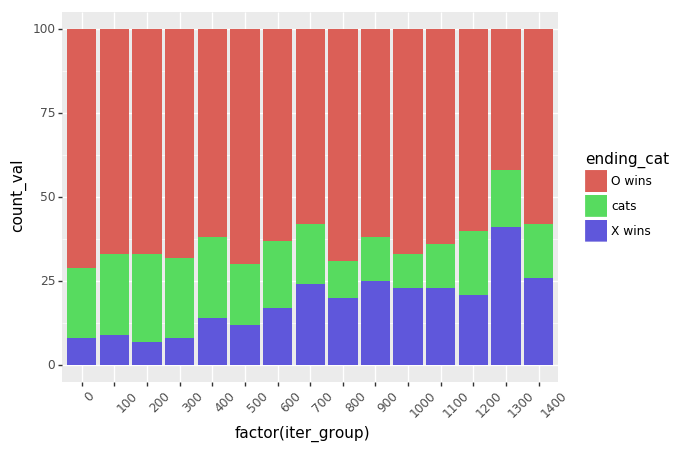

<ggplot: (-9223372029300274663)>

In [946]:
wins_df = pd.DataFrame({'ending':wins})

wins_df['iter'] = range(wins_df.shape[0])

wins_df['iter_group'] = wins_df['iter'].apply(lambda num: num - (num % 100))

wins_df_group = wins_df.groupby('iter_group')['ending'].value_counts().rename(columns = {'': ''}).reset_index().rename(columns = {0:'count_val'})

wins_df_group['ending_cat'] = pd.Categorical(wins_df_group['ending'], categories = ['O wins', 'cats', 'X wins'], ordered = True)

print(wins_df_group.head())

(p9.ggplot(wins_df_group, p9.aes(x = 'factor(iter_group)', fill = 'ending_cat', y = 'count_val')) + 
p9.geom_col() +
p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=0))
)

In [930]:
value_df.n_action.value_counts()

0      3619
2       745
1       725
6       127
7       111
3        93
4        17
5        14
186       4
22        3
24        2
174       2
14        2
23        2
173       2
8         2
20        2
19        1
177       1
28        1
13        1
18        1
27        1
Name: n_action, dtype: int64

In [947]:
value_df.loc[value_df['n_action'] == 13]

,0,1,2,3,4,5,6,7,8,board_str,value,n_action
140,X,O,,,X,,,,,"X,O,,,X,,,,",0.745458,13
4888,X,,O,O,X,,X,O,X,"X,,O,O,X,,X,O,X",1.000000,13
4898,X,O,X,,X,O,O,,X,"X,O,X,,X,O,O,,X",1.000000,13
5447,X,X,O,O,O,X,X,X,O,"X,X,O,O,O,X,X,X,O",0.000000,13
